### import modules

In [2]:
from __future__ import division
from __future__ import print_function

from cvxpy import *
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
sns.set()

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### define functions

In [59]:
def f_hat_compute(K,alpha_hat):
    f_hat = np.dot(alpha_hat,K)
    
    return f_hat

def LOOCV_rbf(x,y,lambda_vec,gamma_vec,loss_func):
    
    cost_vec = np.zeros((lambda_vec.shape[0],gamma_vec.shape[0]))
    lambda_iter = 0
    
    for lambda_val in lambda_vec:
        
            gamma_iter = 0
            
            for gamma_ind in gamma_vec:
                print('lambda = {},gamma = {}'.format(lambda_val,gamma_ind))


                score_ind = []
            
                for valid_ind in np.arange(y.shape[0]):
                    mask = np.ones(np.shape(y))
                    mask[valid_ind] = 0
                    mask = mask.astype('bool')
                    y_train = y[mask]
                    y_test = y[valid_ind]
                    x_train = x[mask]
                    x_test = x[valid_ind]
                    n = x_train.shape[0]


                    K = make_K_mat_rbf(x_train,gamma_ind)
                    ################### cvxpy part
                    # Construct the problem.
                    alpha = Variable(n)
                        #import pdb;pdb.set_trace()
                        
                    if loss_func == 'least_squares':
                        cost = sum_squares(y_train - K*alpha) + lambda_val*quad_form(alpha,K)
                        
                    elif loss_func == 'huber':
                        cost = sum_entries(huber(y_train - K.T*alpha, 1)) + lambda_val*quad_form(alpha,K)

                    objective = Minimize(cost)
                    prob = Problem(objective)
                    result = prob.solve()
                    alpha_hat = alpha.value
                    ####################

                    
                    eval_kernel = kernel_eval_rbf(gamma_ind,x_test,x_train)
                    predict_y = np.array([np.sum(alpha_hat.A1.T*eval_kernel)])
                    cost_ind = cost_func(predict_y,y_test)
                    score_ind.append(cost_ind)


                score = (1/len(score_ind))*np.sum(score_ind)
                cost_vec[lambda_iter][gamma_iter] = score
                
                gamma_iter += 1 
        
            lambda_iter += 1
    
    return cost_vec

def cost_func(prediction,truth):
    
    cost = []
    
    for i in np.arange(prediction.shape[0]):
        
        cost.append(np.linalg.norm(prediction[i]-truth[i]))
    
    cost_total = np.sqrt(np.sum(cost))
    return cost_total

def make_K_mat_rbf(x,gamma):
    K = np.zeros((x.shape[0],x.shape[0]))
    
    for i in np.arange(x.shape[0]):
        for j in np.arange(x.shape[0]):
            K[i][j] = np.exp(-gamma*(np.linalg.norm(x[i]-x[j])**2))
            
    return K

def kernel_eval_rbf(gamma,x_1,x_2):
    eval_kernel = []
    
    for i in np.arange(x_2.shape[0]):
        eval_iter = float(np.exp(-gamma*(np.linalg.norm(x_1-x_2[i])**2)))
        eval_kernel.append(eval_iter)
    return eval_kernel 

def bootstrap_rbf(gamma,lambda_val,x,y,data,num_sets,num_pulls):
    bootstrapped_examples = np.zeros((num_sets,data.shape[0]))
    inds = np.arange(num_pulls)
    for j in np.arange(num_sets):
        inds_choice = np.random.choice(inds,num_pulls)
        x_samp = x[inds_choice]
        y_samp = y[inds_choice]

        f_hat = np.zeros((data.shape))

        K = make_K_mat_rbf(x_samp,gamma)
        alpha_hat = alpha_hat_compute(K,lambda_val,y_samp)

        for i in np.arange(data.shape[0]):
            eval_kernel = kernel_eval_rbf(gamma,float(data[i]),x_samp)
            predict_y = np.sum(alpha_hat.flatten()*np.array(eval_kernel))

            f_hat[i] = predict_y
        
        bootstrapped_examples[j,:] = f_hat
    
    return bootstrapped_examples

def alpha_hat_compute(K,lambda_val,y):
    
    lhs = K + lambda_val*np.identity(np.shape(K)[0])
    alpha_hat = np.linalg.solve(lhs,y)
    
    return alpha_hat

def choose_gamma(x):
    dist_vals = []
    for i in np.arange(x.shape[0]):
        for j in np.arange(i):
            dist_vals.append((np.linalg.norm(x[i] - x[j])**2))
            
    median_val = np.median(np.array(dist_vals))
    gamma = 1/median_val
    return gamma

def plot_function_rbf(x,y,x_cont,f_x,f_hat,kernel,lambda_val,gamma):
    #plt.figure(dpi=600)
    plt.figure()
    plt.plot(x,y,'o',label='original data with noise')
    plt.plot(x_cont,f_x,label='true f(x)')
    plt.plot(x_cont,f_hat,label='f_hat(x)')
    plt.xlabel('x')
    plt.ylabel('f(x) or y')
    plt.title('Data, f(x), and f_hat_x \n for kernel = {}, lambda = {}, gamma = {:.2f}'.format(kernel,lambda_val,gamma))
    plt.legend()
    plt.ylim([-5,50])
    plt.show

    #plt.savefig('hw3_prob2_{}'.format(kernel))
    
def plot_function_rbf_boot(x,y,x_cont,f_x,f_hat,kernel,lambda_val,gamma,lower,upper):
    plt.figure(dpi=600)
    plt.figure()
    plt.plot(x,y,'o',label='original data with noise')
    plt.plot(x_cont,f_x,label='true f(x)')
    plt.plot(x_cont,f_hat,label='f_hat(x)')
    plt.fill_between(x_cont,lower,upper,alpha=0.3,label='95% confidence interval')
    plt.xlabel('x')
    plt.ylabel('f(x) or y')
    plt.title('Data, f(x), f_hat_x, and confidence interval \n for kernel = {}, lambda = {}, gamma = {:.2f}'.format(kernel,lambda_val,gamma))
    plt.legend()
    plt.ylim([-5,5])


    plt.savefig('hw3_prob2_{}_boot'.format(kernel))

### generate data

In [60]:
# Problem data.
n = 30
x_i = np.array([(i-1)/(n-1) for i in np.arange(n)])
eps_i = np.random.randn(n,1)

k= np.array([1,2,3,4])

f_x = np.zeros((x_i.shape[0],1))
index = 0 
for val in x_i:
    f_x[index] =  10*np.sum(val>(k/5))
    index+=1
    
y = f_x + eps_i 
y[14] = 0
    
# generate true f(x)
n_cont = 1000
x_i_cont = np.array([(i-1)/(n-1) for i in np.arange(n)])

f_x_cont = np.zeros((x_i_cont.shape[0],1))
index = 0 
for val in x_i_cont:
    f_x_cont[index] =  10*np.sum(val>(k/5))
    index+=1
    
# generate d 
d = np.zeros((n-1,n))

for i in np.arange(d.shape[0]):
    for j in np.arange(d.shape[1]):
        if i == j:
            d[i,j] = 1
            
        elif i == j - 1:
            d[i,j] = -1 

x_i = np.expand_dims(x_i,axis=1)            
#y = np.expand_dims(y,axis=1)
#f_x_cont = np.expand_dims(f_x_cont,axis=1)
x_i_cont = np.expand_dims(x_i_cont,axis=1)

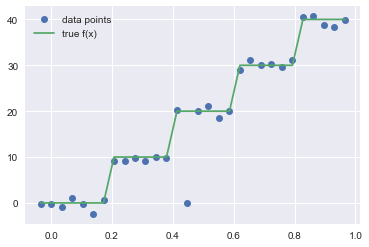

In [61]:
plt.plot(x_i,y,'o',label = 'data points')
plt.plot(x_i_cont,f_x_cont,label = 'true f(x)')
plt.legend()


### least squares

In [62]:
score_vec

array([[ 42.84404716,  11.90668268,   1.90909062,   2.74386793,
          3.70710517,   3.83124885,   4.22820925,   4.41578162,
          4.78882005,   4.72210796,   4.46508389],
       [ 32.40372373,   4.963766  ,   1.8520777 ,   2.1367581 ,
          2.76622896,   3.45336817,   3.85772105,   4.14924078,
          4.36651603,   4.50304991,   4.57829479],
       [ 20.04004216,   3.09376934,   1.90641854,   1.97601368,
          2.45908013,   2.80755673,   3.24082184,   3.61839034,
          3.80351246,   4.08219942,   4.28593646],
       [  9.65823903,   2.57442429,   1.80402042,   1.97625318,
          2.44032199,   2.68285721,   2.98006349,   3.27780828,
          3.53970071,   3.78063956,   3.98795807],
       [  5.92093002,   2.42156616,   1.97075383,   1.87181795,
          2.20613871,   2.45574998,   2.70076222,   2.95487338,
          3.14123236,   3.34441932,   3.53626504],
       [  3.44303355,   3.13491261,   3.04267457,   3.04675643,
          3.04227833,   3.06982687,   3.0

In [63]:
lambda_vec = np.array([1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100])

gamma = choose_gamma(x_i)

gamma_vec = np.arange(gamma-10,gamma+45,5)

#loss_func = 'least_squares'
loss_func = 'huber'

score_vec = LOOCV_rbf(x_i,y,lambda_vec,gamma_vec,loss_func)

best_ind = np.unravel_index(score_vec.argmin(), score_vec.shape)

best_gamma = gamma_vec[best_ind[1]]
best_lambda = lambda_vec[best_ind[0]]

f_hat = np.zeros((x_i_cont.shape))

lambda = 1e-05,gamma = 0.382716049383
lambda = 1e-05,gamma = 5.38271604938
lambda = 1e-05,gamma = 10.3827160494
lambda = 1e-05,gamma = 15.3827160494
lambda = 1e-05,gamma = 20.3827160494
lambda = 1e-05,gamma = 25.3827160494
lambda = 1e-05,gamma = 30.3827160494
lambda = 1e-05,gamma = 35.3827160494
lambda = 1e-05,gamma = 40.3827160494
lambda = 1e-05,gamma = 45.3827160494
lambda = 1e-05,gamma = 50.3827160494
lambda = 0.0001,gamma = 0.382716049383
lambda = 0.0001,gamma = 5.38271604938
lambda = 0.0001,gamma = 10.3827160494
lambda = 0.0001,gamma = 15.3827160494
lambda = 0.0001,gamma = 20.3827160494
lambda = 0.0001,gamma = 25.3827160494
lambda = 0.0001,gamma = 30.3827160494
lambda = 0.0001,gamma = 35.3827160494
lambda = 0.0001,gamma = 40.3827160494
lambda = 0.0001,gamma = 45.3827160494
lambda = 0.0001,gamma = 50.3827160494
lambda = 0.001,gamma = 0.382716049383
lambda = 0.001,gamma = 5.38271604938
lambda = 0.001,gamma = 10.3827160494
lambda = 0.001,gamma = 15.3827160494
lambda = 0.001,gamma = 2

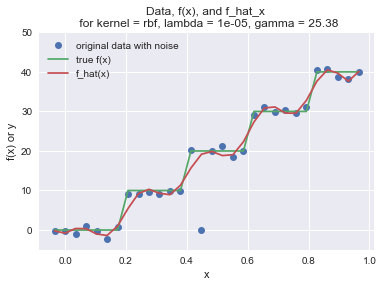

In [71]:
K = make_K_mat_rbf(x_i,best_gamma)
alpha = Variable(n)

if loss_func == 'least_squares':
    cost = sum_squares(y - K*alpha) + best_lambda*quad_form(alpha,K)

elif loss_func == 'huber':
    cost = sum_entries(huber(y - K.T*alpha, 1)) + best_lambda*quad_form(alpha,K)    
    
objective = Minimize(cost)
prob = Problem(objective)
result = prob.solve()
alpha_hat = alpha.value
                        
for i in np.arange(x_i_cont.shape[0]):
    eval_kernel = kernel_eval_rbf(best_gamma,float(x_i_cont[i]),x_i_cont)
    predict_y = np.sum(alpha_hat.A1.T*np.array(eval_kernel))
    f_hat[i] = predict_y


    
plot_function_rbf(x_i,y,x_i_cont,f_x,f_hat,'rbf',best_lambda,best_gamma)

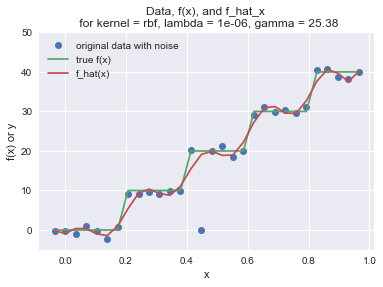

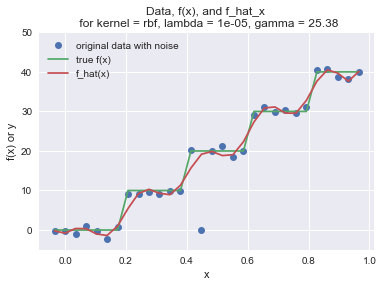

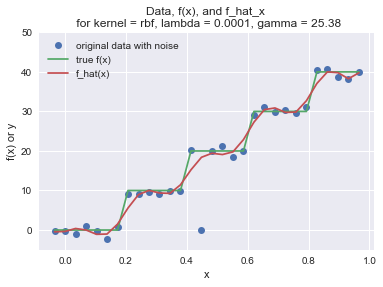

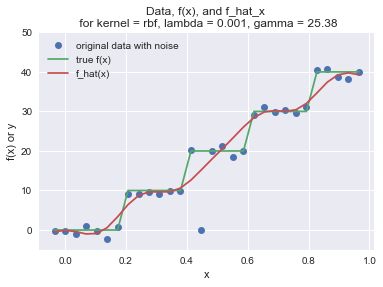

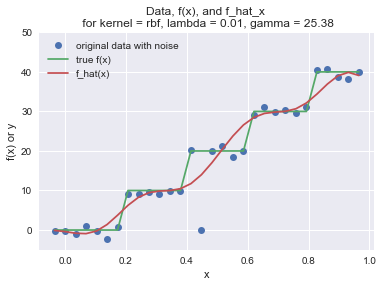

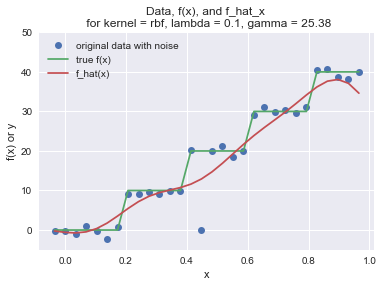

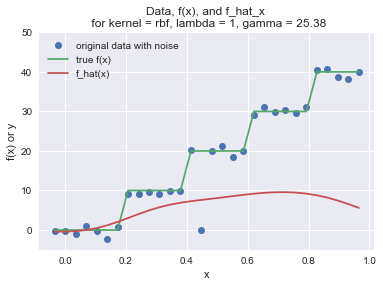

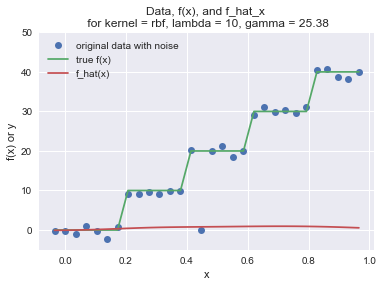

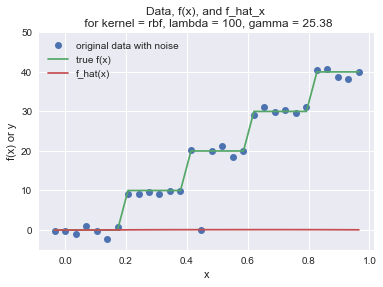

In [68]:
lambda_vec = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100]
gamma = best_gamma
K = make_K_mat_rbf(x_i,gamma)

for lambda_val in lambda_vec:
    
    alpha = Variable(n)
    if loss_func == 'least_squares':
        cost = sum_squares(y - K*alpha) + lambda_val*quad_form(alpha,K)

    elif loss_func == 'huber':
        cost = sum_entries(huber(y - K.T*alpha, 1)) + lambda_val*quad_form(alpha,K)    

    objective = Minimize(cost)
    prob = Problem(objective)
    result = prob.solve()
    alpha_hat = alpha.value
                        
    f_hat = np.zeros((x_i_cont.shape))

    for i in np.arange(x_i_cont.shape[0]):
        eval_kernel = kernel_eval_rbf(gamma,float(x_i_cont[i]),x_i_cont)
        predict_y = np.sum(alpha_hat.A1.T*np.array(eval_kernel))
        f_hat[i] = predict_y
    
    plot_function_rbf(x_i,y,x_i_cont,f_x,f_hat,'rbf',lambda_val,gamma)

### scratch least squares

In [6]:
gamma = choose_gamma(x_i)
K = make_K_mat_rbf(x_i,gamma)
lambda_val = 1e-3

In [31]:
# Construct the problem.
alpha = Variable(n)

cost = sum_squares(y - K*alpha) + lambda_val*quad_form(alpha,K)



objective = Minimize(cost)
prob = Problem(objective)

result = prob.solve()

print(alpha.value)

[[-1175.64020283]
 [  968.11590893]
 [ 1206.52378947]
 [  223.27913169]
 [ -731.71634576]
 [ -956.21112618]
 [ -506.21262302]
 [  124.09414992]
 [  425.22224371]
 [  383.37004052]
 [  269.74419285]
 [  271.23760324]
 [  306.26924165]
 [  134.22841956]
 [ -354.28616764]
 [ -929.84529581]
 [-1110.58103473]
 [ -529.82201129]
 [  671.12914246]
 [ 1762.96155747]
 [ 1831.02869836]
 [  487.65376902]
 [-1588.0027086 ]
 [-2671.53066599]
 [-1510.11780577]
 [ 1115.19278804]
 [ 2895.4270706 ]
 [ 1346.09577175]
 [-2730.99228332]
 [  385.75967503]]


### huber


In [ ]:
# Construct the problem.
x = Variable(n)
objective = Minimize(huber(A*x - b))
constraints = [0 <= x, x <= 1]
prob = Problem(objective, constraints)

# The optimal objective is returned by prob.solve().
result = prob.solve()
# The optimal value for x is stored in x.value.
print(x.value)
# The optimal Lagrange multiplier for a constraint
# is stored in constraint.dual_value.
print(constraints[0].dual_value)